In [7]:
# Gist example of IB wrapper ...
#
# Download API from http://interactivebrokers.github.io/#
#
# Install python API code /IBJts/source/pythonclient $ python3 setup.py install
#
# Note: The test cases, and the documentation refer to a python package called IBApi,
#    but the actual package is called ibapi. Go figure.
#
# Get the latest version of the gateway:
# https://www.interactivebrokers.com/en/?f=%2Fen%2Fcontrol%2Fsystemstandalone-ibGateway.php%3Fos%3Dunix
#    (for unix: windows and mac users please find your own version)
#
# Run the gateway
#
# user: edemo
# pwd: demo123
#

from ibapi.wrapper import EWrapper
from ibapi.client import EClient
from ibapi.contract import Contract as IBcontract
from threading import Thread
import queue
import datetime

In [8]:
DEFAULT_HISTORIC_DATA_ID=50
DEFAULT_GET_CONTRACT_ID=43

## marker for when queue is finished
FINISHED = object()
STARTED = object()
TIME_OUT = object()

class finishableQueue(object):

    def __init__(self, queue_to_finish):

        self._queue = queue_to_finish
        self.status = STARTED

    def get(self, timeout):
        """
        Returns a list of queue elements once timeout is finished, or a FINISHED flag is received in the queue
        :param timeout: how long to wait before giving up
        :return: list of queue elements
        """
        contents_of_queue=[]
        finished=False

        while not finished:
            try:
                current_element = self._queue.get(timeout=timeout)
                if current_element is FINISHED:
                    finished = True
                    self.status = FINISHED
                else:
                    contents_of_queue.append(current_element)
                    ## keep going and try and get more data

            except queue.Empty:
                ## If we hit a time out it's most probable we're not getting a finished element any time soon
                ## give up and return what we have
                finished = True
                self.status = TIME_OUT


        return contents_of_queue

    def timed_out(self):
        return self.status is TIME_OUT





class TestWrapper(EWrapper):
    """
    The wrapper deals with the action coming back from the IB gateway or TWS instance
    We override methods in EWrapper that will get called when this action happens, like currentTime
    Extra methods are added as we need to store the results in this object
    """

    def __init__(self):
        self._my_contract_details = {}
        self._my_historic_data_dict = {}

    ## error handling code
    def init_error(self):
        error_queue=queue.Queue()
        self._my_errors = error_queue

    def get_error(self, timeout=5):
        if self.is_error():
            try:
                return self._my_errors.get(timeout=timeout)
            except queue.Empty:
                return None

        return None

    def is_error(self):
        an_error_if=not self._my_errors.empty()
        return an_error_if

    def error(self, id, errorCode, errorString):
        ## Overriden method
        errormsg = "IB error id %d errorcode %d string %s" % (id, errorCode, errorString)
        self._my_errors.put(errormsg)


    ## get contract details code
    def init_contractdetails(self, reqId):
        contract_details_queue = self._my_contract_details[reqId] = queue.Queue()

        return contract_details_queue

    def contractDetails(self, reqId, contractDetails):
        ## overridden method

        if reqId not in self._my_contract_details.keys():
            self.init_contractdetails(reqId)

        self._my_contract_details[reqId].put(contractDetails)

    def contractDetailsEnd(self, reqId):
        ## overriden method
        if reqId not in self._my_contract_details.keys():
            self.init_contractdetails(reqId)

        self._my_contract_details[reqId].put(FINISHED)

    ## Historic data code
    def init_historicprices(self, tickerid):
        historic_data_queue = self._my_historic_data_dict[tickerid] = queue.Queue()

        return historic_data_queue


    def historicalData(self, tickerid , bar):

        ## Overriden method
        ## Note I'm choosing to ignore barCount, WAP and hasGaps but you could use them if you like
        bardata=(bar.date, bar.open, bar.high, bar.low, bar.close, bar.volume)

        historic_data_dict=self._my_historic_data_dict

        ## Add on to the current data
        if tickerid not in historic_data_dict.keys():
            self.init_historicprices(tickerid)

        historic_data_dict[tickerid].put(bardata)

    def historicalDataEnd(self, tickerid, start:str, end:str):
        ## overriden method

        if tickerid not in self._my_historic_data_dict.keys():
            self.init_historicprices(tickerid)

        self._my_historic_data_dict[tickerid].put(FINISHED)




class TestClient(EClient):
    """
    The client method
    We don't override native methods, but instead call them from our own wrappers
    """
    def __init__(self, wrapper):
        ## Set up with a wrapper inside
        EClient.__init__(self, wrapper)


    def resolve_ib_contract(self, ibcontract, reqId=DEFAULT_GET_CONTRACT_ID):

        """
        From a partially formed contract, returns a fully fledged version
        :returns fully resolved IB contract
        """

        ## Make a place to store the data we're going to return
        contract_details_queue = finishableQueue(self.init_contractdetails(reqId))

        print("Getting full contract details from the server... ")

        self.reqContractDetails(reqId, ibcontract)

        ## Run until we get a valid contract(s) or get bored waiting
        MAX_WAIT_SECONDS = 10
        new_contract_details = contract_details_queue.get(timeout = MAX_WAIT_SECONDS)

        while self.wrapper.is_error():
            print(self.get_error())

        if contract_details_queue.timed_out():
            print("Exceeded maximum wait for wrapper to confirm finished - seems to be normal behaviour")

        if len(new_contract_details)==0:
            print("Failed to get additional contract details: returning unresolved contract")
            return ibcontract

        if len(new_contract_details)>1:
            print("got multiple contracts using first one")

        new_contract_details=new_contract_details[0]

        resolved_ibcontract=new_contract_details.contract

        return resolved_ibcontract


    def get_IB_historical_data(self, ibcontract, durationStr="5 D", barSizeSetting="5 mins",
                               tickerid=DEFAULT_HISTORIC_DATA_ID):

        """
        Returns historical prices for a contract, up to today
        ibcontract is a Contract
        :returns list of prices in 4 tuples: Open high low close volume
        """


        ## Make a place to store the data we're going to return
        historic_data_queue = finishableQueue(self.init_historicprices(tickerid))

        # Request some historical data. Native method in EClient
        self.reqHistoricalData(
            tickerid,  # tickerId,
            ibcontract,  # contract,
            datetime.datetime.today().strftime("%Y%m%d %H:%M:%S %Z"),  # endDateTime,
            durationStr,  # durationStr,
            barSizeSetting,  # barSizeSetting,
            "Midpoint",  # whatToShow,
            1,  # useRTH,
            1,  # formatDate
            False,  # KeepUpToDate <<==== added for api 9.73.2
            [] ## chartoptions not used
        )



        ## Wait until we get a completed data, an error, or get bored waiting
        MAX_WAIT_SECONDS = 10
        print("Getting historical data from the server... could take %d seconds to complete " % MAX_WAIT_SECONDS)

        historic_data = historic_data_queue.get(timeout = MAX_WAIT_SECONDS)

        while self.wrapper.is_error():
            print(self.get_error())

        if historic_data_queue.timed_out():
            print("Exceeded maximum wait for wrapper to confirm finished - seems to be normal behaviour")

        self.cancelHistoricalData(tickerid)


        return historic_data



class TestApp(TestWrapper, TestClient):
    def __init__(self, ipaddress, portid, clientid):
        TestWrapper.__init__(self)
        TestClient.__init__(self, wrapper=self)

        self.connect(ipaddress, portid, clientid)

        thread = Thread(target = self.run)
        thread.start()

        setattr(self, "_thread", thread)

        self.init_error()

In [26]:
#if __name__ == '__main__':

app = TestApp("127.0.0.1", 7497, 77)

historic_data = []

for i in range(5):
    ibcontract = IBcontract()
    # ibcontract.secType = "CASH"
    # ibcontract.symbol="EUR"
    # ibcontract.currency = "USD"
    # ibcontract.exchange="IDEALPRO"

    ibcontract.secType = "STK"
    ibcontract.symbol="C"
    ibcontract.exchange="NYSE"

    resolved_ibcontract=app.resolve_ib_contract(ibcontract)

    historic = app.get_IB_historical_data(resolved_ibcontract, durationStr="10 D", barSizeSetting="1 min") + historic

print(historic_data)

app.disconnect()

Getting full contract details from the server... 
IB error id -1 errorcode 2104 string Market data farm connection is OK:usfuture.nj
IB error id -1 errorcode 2104 string Market data farm connection is OK:usfarm.nj
IB error id -1 errorcode 2104 string Market data farm connection is OK:usopt
IB error id -1 errorcode 2104 string Market data farm connection is OK:usfarm
IB error id -1 errorcode 2106 string HMDS data farm connection is OK:ushmds.us
IB error id -1 errorcode 2106 string HMDS data farm connection is OK:njhmds
IB error id -1 errorcode 2106 string HMDS data farm connection is OK:hkhmds
IB error id -1 errorcode 2106 string HMDS data farm connection is OK:ushmds
Getting historical data from the server... could take 10 seconds to complete 
[('20190103  22:30:00', 53.365, 53.575, 53.35, 53.445, -1), ('20190103  22:30:30', 53.445, 53.615, 53.445, 53.5, -1), ('20190103  22:31:00', 53.5, 53.605, 53.495, 53.55, -1), ('20190103  22:31:30', 53.55, 53.605, 53.49, 53.525, -1), ('20190103  2

In [27]:
historic_data

[('20190103  22:30:00', 53.365, 53.575, 53.35, 53.445, -1),
 ('20190103  22:30:30', 53.445, 53.615, 53.445, 53.5, -1),
 ('20190103  22:31:00', 53.5, 53.605, 53.495, 53.55, -1),
 ('20190103  22:31:30', 53.55, 53.605, 53.49, 53.525, -1),
 ('20190103  22:32:00', 53.525, 53.535, 53.405, 53.415, -1),
 ('20190103  22:32:30', 53.415, 53.545, 53.39, 53.41, -1),
 ('20190103  22:33:00', 53.41, 53.53, 53.305, 53.53, -1),
 ('20190103  22:33:30', 53.53, 53.565, 53.455, 53.545, -1),
 ('20190103  22:34:00', 53.545, 53.62, 53.475, 53.48, -1),
 ('20190103  22:34:30', 53.48, 53.48, 53.32, 53.46, -1),
 ('20190103  22:35:00', 53.46, 53.46, 53.285, 53.315, -1),
 ('20190103  22:35:30', 53.315, 53.33, 53.255, 53.275, -1),
 ('20190103  22:36:00', 53.275, 53.275, 53.095, 53.095, -1),
 ('20190103  22:36:30', 53.095, 53.105, 52.94, 52.955, -1),
 ('20190103  22:37:00', 52.955, 53.005, 52.92, 52.925, -1),
 ('20190103  22:37:30', 52.925, 53.045, 52.925, 53.03, -1),
 ('20190103  22:38:00', 53.03, 53.035, 52.97, 52.9

In [28]:
len(historic_data)

780

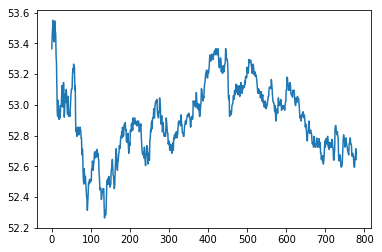

In [29]:
from matplotlib import pyplot as plt

price_ls = [x[1] for x in historic_data] 

plt.plot(price_ls)
plt.show()